In [7]:
import numpy as np
import scipy.stats as sps
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10, 7.5)
from pyvbmc.likelihood_free import pseudo_likelihood
from pyvbmc.vbmc import VBMC

In [8]:
D = 2
N = 1000

sim_data = sps.multivariate_normal.rvs(cov=np.eye(D), size=N)
d_obs = sps.multivariate_normal.rvs(cov=np.eye(D), size=N)
def fake_sim(theta):
    return np.linalg.norm(theta) * sim_data

def fake_summary(d_theta):
    return np.mean(np.var(d_theta, axis=0))

epsilon = 1.0
a = 0.8
p = 0.99
ll, ll_plot = pseudo_likelihood(
    fake_sim,
    fake_summary,
    data=d_obs,
    epsilon=epsilon,
    a=a,
    p=p,
    return_plot_fun=True
)

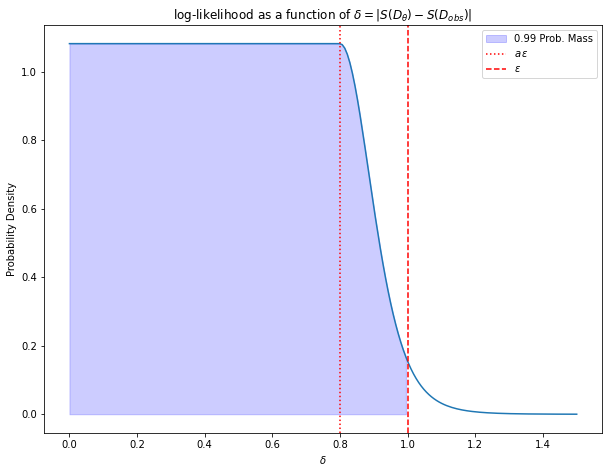

In [9]:
delta = np.linspace(0,1.5,200)
ll_delta = np.exp(np.array([ll_plot(di) for di in delta]))
plt.plot(delta, ll_delta);
plt.fill_between(
        x=delta, 
        y1=np.exp(ll_plot(delta)), 
        where=(0 <= delta) & (delta <= epsilon),
        color="b",
        alpha=0.2,
        label=f"{p} Prob. Mass"
);
plt.axvline(x=a*epsilon, color="r", linestyle="dotted", label=r"$a \, \epsilon$");
plt.axvline(x=epsilon, color="r", linestyle="dashed", label=r"$\epsilon$");
plt.title(r"log-likelihood as a function of $\delta = |S(D_{\theta}) - S(D_{obs})|$");
plt.xlabel(r"$\delta$");
plt.ylabel("Probability Density");
plt.legend(loc="upper right");

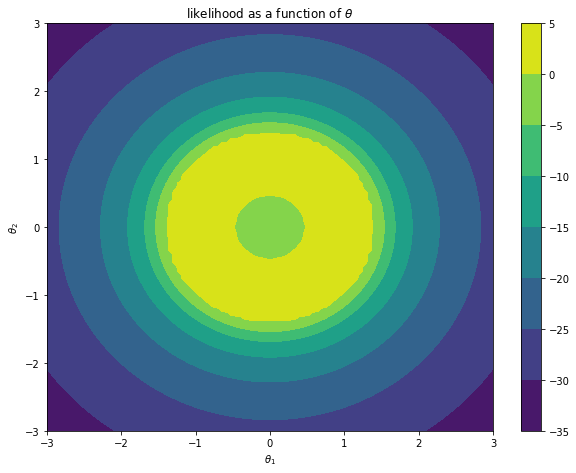

In [10]:
M = 100
xlist = np.linspace(-3, 3, M)
ylist = np.linspace(-3, 3, M)
X, Y = np.meshgrid(xlist, ylist)
thetas = np.vstack([Y.ravel(), X.ravel()]).T
Z = ll(thetas).reshape(M,M)

fig,ax=plt.subplots(1,1)
cp = ax.contourf(X, Y, Z)
fig.colorbar(cp) # Add a colorbar to a plot
ax.set_title(r"likelihood as a function of $\theta$")
ax.set_xlabel(r"$\theta_{1}$")
ax.set_ylabel(r"$\theta_{2}$")
plt.show();

Beginning variational optimization assuming EXACT observations of the log-joint.
 Iteration  f-count    Mean[ELBO]    Std[ELBO]    sKL-iter[q]   K[q]  Convergence  Action
     0         10          -4.69         0.94     81506.87        2        inf     start warm-up


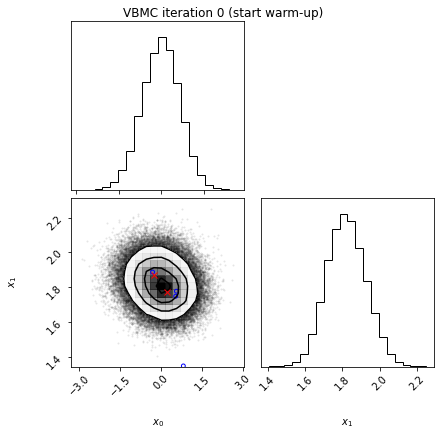

 Iteration  f-count    Mean[ELBO]    Std[ELBO]    sKL-iter[q]   K[q]  Convergence  Action
     1         15          -4.33         1.10         0.19        2        inf     


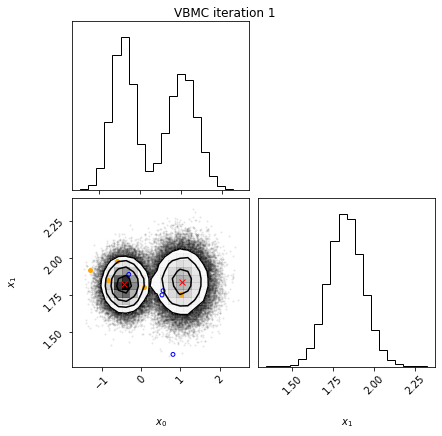

 Iteration  f-count    Mean[ELBO]    Std[ELBO]    sKL-iter[q]   K[q]  Convergence  Action
     2         20          -4.78         0.31         0.57        2       15.9     


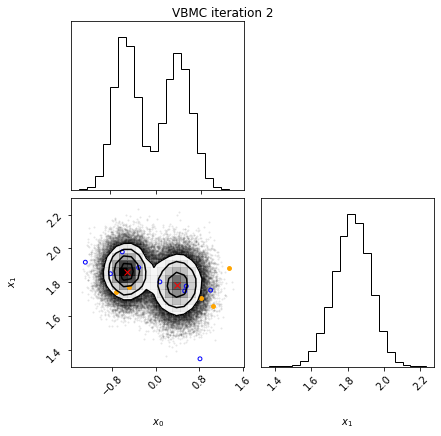

 Iteration  f-count    Mean[ELBO]    Std[ELBO]    sKL-iter[q]   K[q]  Convergence  Action
     3         25          -4.71         0.17         0.12        2       3.59     


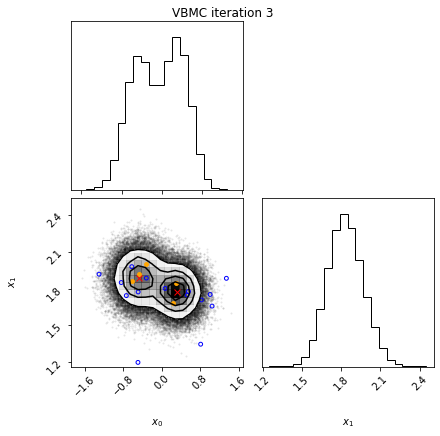

 Iteration  f-count    Mean[ELBO]    Std[ELBO]    sKL-iter[q]   K[q]  Convergence  Action
     4         30          -4.84         0.16         0.16        2       4.63     end warm-up


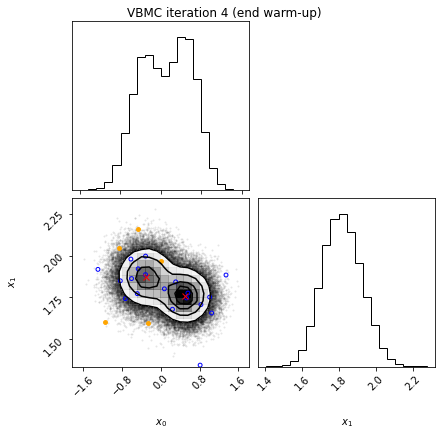

In [ ]:
sim_data = sps.multivariate_normal.rvs(cov=np.eye(D), size=N)
d_obs = 2 * sps.multivariate_normal.rvs(cov=np.eye(D), size=N)

def fake_sim(theta):  # Deterministic simulation
    return np.linalg.norm(theta) * sim_data

# Variance close to 1 for d_obs, close to norm(theta) for d_theta:
def fake_summary(d_theta):
    return np.mean(np.var(d_theta, axis=0))

llfun = pseudo_likelihood(fake_sim, fake_summary, data=d_obs, epsilon=1.0)

def ltarget(t):  # Pseudo-likelihood + wide prior
    return llfun(t) + sps.multivariate_normal.logpdf(t, cov=8 * np.eye(D))

x0 = np.array([[0, 1]])
lb = np.full((1, D), -np.inf)
ub = np.full((1, D), np.inf)
plb = -2 * np.ones((1, D))
pub = 2 * np.ones((1, D))
options = {
    # "searchacqfcn": ["@acqviqr_vbmc"],
    "plot": True
}

vbmc = VBMC(ltarget, x0, lb, ub, plb, pub, user_options=options)
vbmc.optimize()